In [1]:
import numpy as np
import ase.db
from tpot import TPOTRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import math
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import sklearn.gaussian_process as gp
import random

# Adsorption Energy Model

In [2]:
x = np.loadtxt("../../Feature/g6/ptag_feature.csv", delimiter=",",encoding='utf-8-sig')
y = np.loadtxt("../../Feature/g6/energy.csv", delimiter=",",encoding='utf-8-sig')
x.shape

(161, 21)

In [3]:
kernel = gp.kernels.ConstantKernel(constant_value=1,constant_value_bounds=(1e-1,1e3)) *gp.kernels.RBF(length_scale=10, length_scale_bounds=(1e-1, 1e3))
gpr_model = gp.GaussianProcessRegressor(kernel=kernel,
                                        n_restarts_optimizer=50,
                                        alpha=0.1,
                                        normalize_y=True)

In [4]:
standardscaler = StandardScaler()
pca = PCA(0.99)
MAE_TRAIN = []
R2_TRAIN = []
MAE_TEST = []
R2_TEST = []

for i in range(0,10):
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8,test_size=0.2, random_state=i)
    standardscaler = StandardScaler()
    pca = PCA(0.99)
    X_train = standardscaler.fit_transform(x_train)
    X_train = pca.fit_transform(X_train)
    print('x_train shape after PCA:',X_train.shape)
    X_test = standardscaler.transform(x_test)
    X_test = pca.transform(X_test)  
    gpr_model.fit(X_train, y_train)
    y_train_predict=gpr_model.predict(X_train)
    y_test_predict=gpr_model.predict(X_test)
    MAE_train = mean_absolute_error(y_pred=y_train_predict, y_true=y_train)
    R2_train = r2_score(y_pred=y_train_predict, y_true=y_train)
    MAE_test = mean_absolute_error(y_pred=y_test_predict, y_true=y_test)
    R2_test = r2_score(y_pred=y_test_predict, y_true=y_test)
    MAE_TRAIN.append(MAE_train)
    MAE_TEST.append(MAE_test)
    R2_TRAIN.append(R2_train)
    R2_TEST.append(R2_test)
    
print('MAE train:',np.mean(MAE_TRAIN),'R2 train:',np.mean(R2_TRAIN))
print('MAE train:',np.mean(MAE_TEST),'R2 train:',np.mean(R2_TEST))

x_train shape after PCA: (128, 13)
x_train shape after PCA: (128, 13)
x_train shape after PCA: (128, 13)
x_train shape after PCA: (128, 13)
x_train shape after PCA: (128, 13)
x_train shape after PCA: (128, 13)
x_train shape after PCA: (128, 13)
x_train shape after PCA: (128, 13)
x_train shape after PCA: (128, 13)
x_train shape after PCA: (128, 13)
MAE train: 0.06343251508616099 R2 train: 0.9379939459385342
MAE train: 0.09062972810048658 R2 train: 0.8645104868351868


(161, 13) (161,)


(array([18., 31., 37., 24., 12.,  9., 11.,  5.,  4., 10.]),
 array([0.0279841 , 0.03456235, 0.04114059, 0.04771884, 0.05429708,
        0.06087532, 0.06745357, 0.07403181, 0.08061005, 0.0871883 ,
        0.09376654]),
 <BarContainer object of 10 artists>)

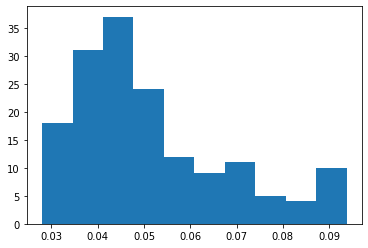

In [5]:
X_train = x = np.vstack((x_train,x_test))
X_train = standardscaler.fit_transform(X_train)
X_train = pca.fit_transform(X_train)
y_train = y = np.concatenate((y_train,y_test),axis=0) 
print(X_train.shape,y_train.shape)
gpr_model.fit(X_train, y_train)
y_train_predict,sigma=gpr_model.predict(X_train,return_std=True)
plt.hist(sigma)

x_train shape after PCA: (128, 13)
MAE train: 0.05977608347585574 R2 train: 0.9341841460806097
MAE test: 0.09186653818615236 R2 test: 0.9234446264766172


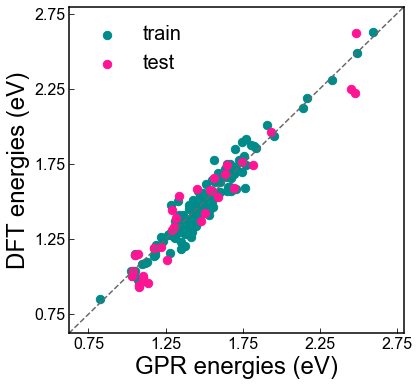

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, test_size=0.2, random_state=6)
standardscaler = StandardScaler()
pca = PCA(0.99)
X_train = standardscaler.fit_transform(x_train)
X_train = pca.fit_transform(X_train)
print('x_train shape after PCA:',X_train.shape)
X_test = standardscaler.transform(x_test)
X_test = pca.transform(X_test)  
gpr_model.fit(X_train, y_train)
y_train_predict=gpr_model.predict(X_train)
y_test_predict=gpr_model.predict(X_test)
MAE_train = mean_absolute_error(y_pred=y_train_predict, y_true=y_train)
R2_train = r2_score(y_pred=y_train_predict, y_true=y_train)
MAE_test = mean_absolute_error(y_pred=y_test_predict, y_true=y_test)
R2_test = r2_score(y_pred=y_test_predict, y_true=y_test)


print('MAE train:',MAE_train,'R2 train:',R2_train)
print('MAE test:',MAE_test,'R2 test:',R2_test)

# Make the joint plot
plt.rc('font',family='Arial')
plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.direction']='in'
plt.rcParams['axes.linewidth'] = 1.5  # Make the border thicker

xmin=min(y_train_predict)-0.2
xmax=max(y_train_predict)+0.2
x_lim=np.linspace(xmin,xmax,20)

fig,ax=plt.subplots(figsize=(6,6))
plt.xlim([xmin,xmax])
plt.ylim([xmin,xmax])
# Customize x and y ticks
plt.xticks([0.75,1.25,1.75,2.25,2.75])
plt.yticks([0.75,1.25,1.75,2.25,2.75])

plt.scatter(y_train_predict,y_train,color='darkcyan',s=70)
plt.scatter(y_test_predict,y_test,color='deeppink',s=70)
plt.legend(['train','test'],fontsize=20, frameon = False)
plt.plot(x_lim,x_lim,linestyle='--',color='dimgray')
# Increase the font size of tick labels
ax.tick_params(axis='both', which='major', length=5, labelsize=16)


plt.xlabel('GPR energies (eV)',fontsize=24)
plt.ylabel('DFT energies (eV)',fontsize=24)
plt.savefig('parity plot.eps',dpi=1000,bbox_inches='tight')

x_train shape after PCA: (161, 13)


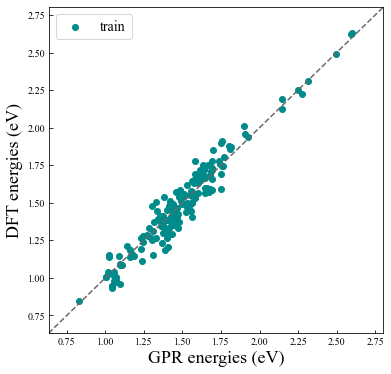

In [7]:
# Use all data to train the model 
x_train = x
y_train = y
standardscaler = StandardScaler()
pca = PCA(0.99)

X_train = standardscaler.fit_transform(x_train)
X_train = pca.fit_transform(X_train)
print('x_train shape after PCA:',X_train.shape) 
gpr_model.fit(X_train, y_train)
y_train_predict=gpr_model.predict(X_train)

# Make the joint plot
plt.rc('font',family='Times New Roman')
plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.direction']='in'
xmin=min(y_train_predict)-0.2
xmax=max(y_train_predict)+0.2
x_lim=np.linspace(xmin,xmax,20)

fig,ax=plt.subplots(figsize=(6,6))
plt.xlim([xmin,xmax])
plt.ylim([xmin,xmax])
plt.scatter(y_train_predict,y_train,color='darkcyan')
plt.legend(['train','test'],fontsize=14)
plt.plot(x_lim,x_lim,linestyle='--',color='dimgray')

plt.xlabel('GPR energies (eV)',fontsize=18)
plt.ylabel('DFT energies (eV)',fontsize=18)
plt.savefig('parity plot all.png',dpi=1000)

In [8]:
# save gpr model and preprocessing model 
import pickle
from sklearn.pipeline import Pipeline

s = pickle.dumps(gpr_model)
with open('GPRmodel.model','wb+') as f:
    f.write(s)
    
steps = [('scaler', standardscaler),('pca', pca)]
pipeline = Pipeline(steps)
with open('Preprocessing.pkl', 'wb+') as f:
    pickle.dump(pipeline, f)

In [9]:
# load data processing modual
import pickle
preprocessing = pickle.load(open("Preprocessing.pkl", "rb"))

# load ml model
f = open('GPRmodel.model','rb') #注意此处model是rb
s = f.read()
model = pickle.loads(s)
model = pickle.load(open("GPRmodel.model", "rb"))

In [10]:
# predict all data set 
ratio_all = np.loadtxt("../../Feature/g6/ratio_all_sites.csv",delimiter=",",encoding='utf-8-sig')
x_all = np.loadtxt("../../Feature/g6/ptag_feature_all_sites.csv", delimiter=",",encoding='utf-8-sig')
x_all = preprocessing.transform(x_all)
y_all_predict,y_all_activity_sigma = model.predict(x_all, return_std=True)
Activity = [0.6*(eo+0.23)-1.376 if eo < 1.58 else -1.645*(eo+0.23)+2.688 for eo in y_all_predict]
Activity_sigma = [0.6*y_all_activity_sigma[i] if y_all_predict[i] <1.58 else 1.645*y_all_activity_sigma[i] for i in range(len(y_all_predict))]
np.savetxt("../../Feature/g6/energy_all_sites_predicted.csv", y_all_predict, delimiter=',')
np.savetxt("../../Feature/g6/activity_all_sites_predicted.csv", Activity, delimiter=',')
np.savetxt("../../Feature/g6/activity_sigma_all_sites.csv", Activity_sigma, delimiter=',')
uid = [i for i in range(len(ratio_all))] 
sid = [i//16 for i in uid]
ratio_activity_sigma =  pd.DataFrame({'ratio':ratio_all,'activity':Activity,'sigma':Activity_sigma,'uid':uid,'sid':sid})
ratio_activity_sigma = ratio_activity_sigma.sort_values(by=['ratio','sid'],ascending = True)
ratio_activity_sigma.to_csv("../../Feature/g6/ratio_activity_sigma.csv",sep=',',index=False)

In [11]:
# print maximum activity
print(ratio_activity_sigma.groupby('sid')['ratio'].mean())
print(ratio_activity_sigma.groupby('sid')['activity'].mean())
print(ratio_activity_sigma.groupby('sid')['activity'].mean().max())

sid
0     0.000000
1     0.125000
2     0.250000
3     0.375000
4     0.500000
5     0.625000
6     0.750000
7     0.875000
8     1.000000
9     0.125000
10    0.250000
11    0.375000
12    0.500000
13    0.625000
14    0.750000
15    0.875000
16    0.125000
17    0.250000
18    0.375000
19    0.500000
20    0.625000
21    0.750000
22    0.875000
23    0.281250
24    0.125000
25    0.250000
26    0.375000
27    0.500000
28    0.625000
29    0.750000
30    0.875000
31    0.281250
32    0.125000
33    0.250000
34    0.375000
35    0.500000
36    0.625000
37    0.750000
38    0.875000
39    0.093750
40    0.125000
41    0.250000
42    0.375000
43    0.500000
44    0.625000
45    0.750000
46    0.875000
47    0.265625
48    0.125000
49    0.250000
50    0.375000
51    0.500000
52    0.625000
53    0.750000
54    0.875000
55    0.656250
Name: ratio, dtype: float64
sid
0    -0.449708
1    -0.412543
2    -0.482262
3    -0.457054
4    -0.646523
5    -1.051505
6    -0.818267
7    -1.028895
8   

In [12]:
Ratio = ratio_activity_sigma.groupby('sid')['ratio'].mean().to_numpy()
Activity = ratio_activity_sigma.groupby('sid')['activity'].mean().to_numpy()
Ratio_Activity_MEAN = pd.DataFrame({'ratio':Ratio, 'activity':Activity})
Ratio_Activity_MAX = Ratio_Activity_MEAN.groupby('ratio')['activity'].max().reset_index()
print(Ratio_Activity_MAX)
Ratio_Activity_MAX.to_csv('ratio_activity_ptag.csv')

       ratio  activity
0   0.000000 -0.449708
1   0.093750 -0.407849
2   0.125000 -0.357411
3   0.250000 -0.335320
4   0.265625 -0.391687
5   0.281250 -0.440829
6   0.375000 -0.355470
7   0.500000 -0.379958
8   0.625000 -0.376830
9   0.656250 -0.399548
10  0.750000 -0.387263
11  0.875000 -0.434745
12  1.000000 -1.220673
